## Trayendo datos

In [16]:
import pandas as pd
import pylab as plt
from tusp import string2ts, ts2string
from bot import prepareData,marketReturn
import numpy as np
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 8

# trayendo y preparando datos
df  = prepareData(pair="USDT_BTC",
                  start=string2ts("2018-08-15 02:00:00"),
                  end=string2ts("2018-08-18 02:00:00"),
                  period=3600/12)
per = 0.95


## Parámetros vía stockstacks

In [50]:
from stockstats import StockDataFrame

stock = StockDataFrame.retype(df.copy())
stock["rsi_14"];
stock["macd"];
stock["macds"];
stock["cci"];
stock["wr_14"];

## Creando estrategia ideal y separando en train y test 

In [18]:
from mldata import ml_data
from orders import orders
from profit import profit

df["ml_data"] = ml_data(df["close"],la=10, pl=False)

ts_1 = df.shift(1)
ts_2 = df.shift(2)
ts_3 = df.shift(3)
#tf_1 = df.shift(-1)

df["feat1"] = ts_1["close"] > ts_2["close"]
df["feat2"] = ts_2["close"] > ts_3["close"]

w4 = pd.DataFrame(data={"w":df["ml_data"].values,"price":df["close"]})
w4["orders"] = orders(w4["w"])
w4["w"] = w4["w"].shift(1)
relReturn, vecReturn4 = profit(w4)
print "Retorno de estrategia ideal: %s"%(relReturn*100)

data = pd.DataFrame(data={"feat1": df["feat1"], "feat2":df["feat2"], 
                       "rsi":stock["rsi_14"].shift(-1).fillna(method='ffill'), 
                       "cci":stock["cci"].shift(-1).fillna(method='ffill'),
                       "dma":stock["dma"], "kdjj":stock["kdjj"], "trix":stock["trix"], "ideal_w":w4["w"]})

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.fillna(method='bfill', inplace=True)

train = data[1:int(len(data)*per)]
test = data[int(len(data)*per):]

train.tail(2)

Retorno de estrategia ideal: 26.8369543478


,cci,dma,feat1,feat2,ideal_w,kdjj,rsi,trix
date,,,,,,,,
2018-08-17 22:15:00,-70.439861,-36.802726,True,False,1.0,28.076093,35.546155,-0.035504
2018-08-17 22:20:00,-62.208319,-41.999272,True,True,1.0,26.494793,37.699584,-0.038300


## Importando modelos de clasificación

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import BernoulliRBM
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

features = ['cci', 'dma', 'feat1', 'feat2', 'kdjj', 'rsi', 'trix']

X, y = data[features], data["ideal_w"]

n_folds = 5

## Validación cruzada XGBoost 

Se obtienen los valores:
* n_estimators = 9
* learning_rate = 0.75
* gamma = 12

### base_score

In [20]:
# tuneado de base_score

params = np.linspace(0.01, 0.99, 10)
#params = np.logspace(-10, 0, 10)
xgb = XGBClassifier()

scores = list()
scores_std = list()

for bs in params:
    xgb.base_score = bs
    
    this_scores = cross_val_score(xgb, X, y, n_jobs=-1, scoring='precision', cv =n_folds);
    
    # calculando promedio y std de las validaciones cruzadas
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))
    

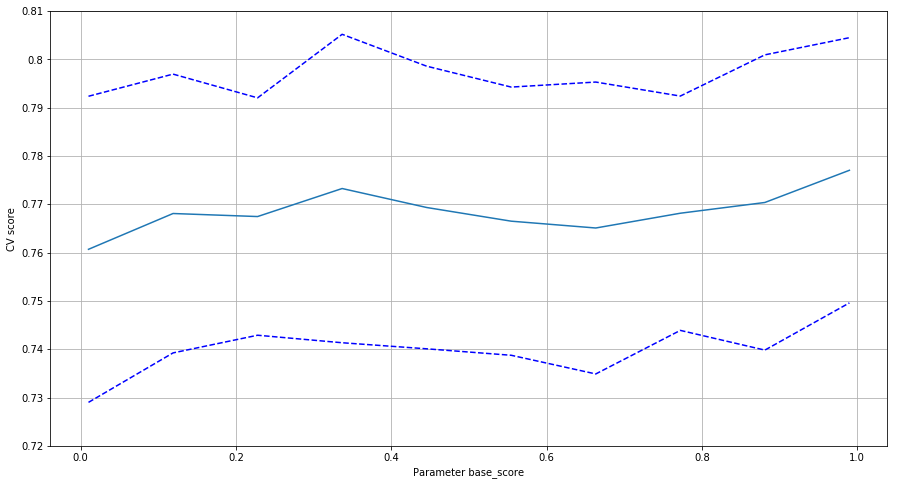

In [21]:
plt.plot(params, scores)
plt.plot(params, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(params, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter base_score')
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### n_estimators

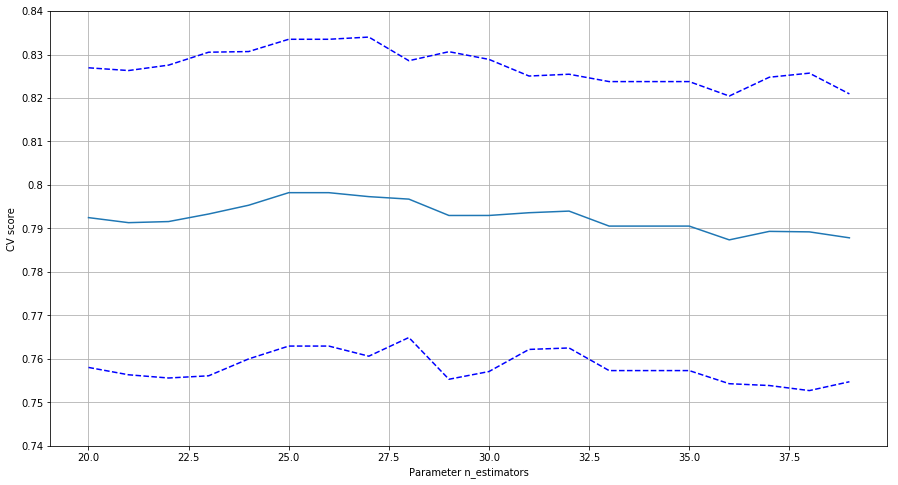

In [22]:
parameter = "n_estimators"
params = range(20,40)
#params = np.logspace(-10, 0, 10)
xgb = XGBClassifier()

scores = list()
scores_std = list()

for bs in params:
    xgb.n_estimators = bs
    
    this_scores = cross_val_score(xgb, X, y, n_jobs=-1, scoring='precision', cv= n_folds)
    
    # calculando promedio y std de las validaciones cruzadas
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

plt.plot(params, scores)
plt.plot(params, np.array(scores) + np.array(scores_std), 'b--')
plt.plot(params, np.array(scores) - np.array(scores_std), 'b--')
locs, labels = plt.yticks()
plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### learning_rate

0.0697989949749


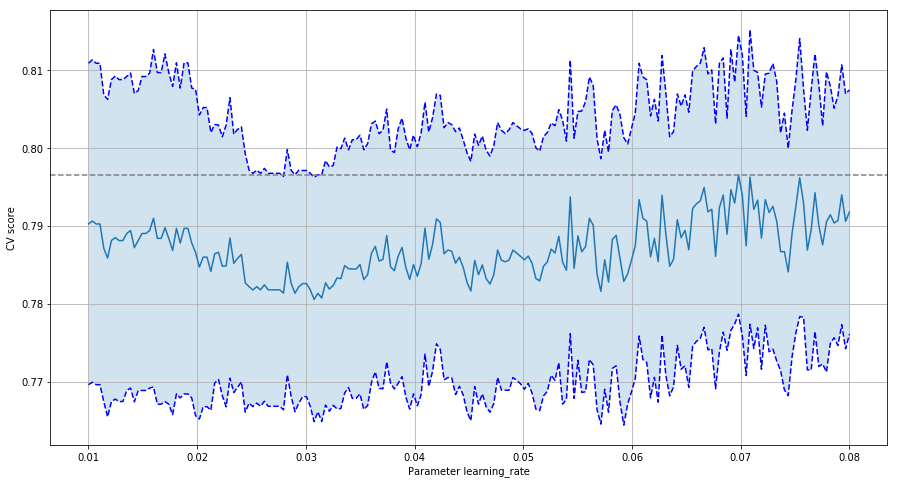

In [23]:
parameter = "learning_rate"
alphas = np.linspace(0.01, 0.08, 200)
tuned_parameters = [{parameter: alphas}]


clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1,scoring='precision')
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### max_depth

2


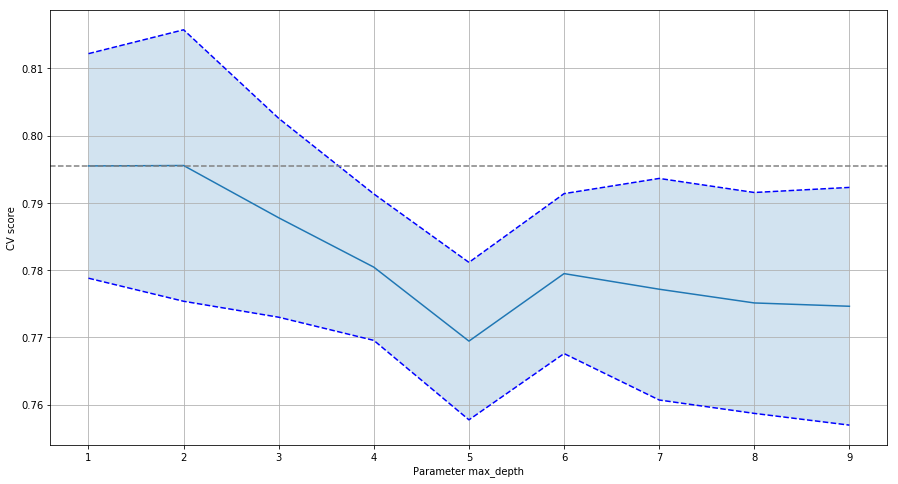

In [24]:
parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, scoring='precision')
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### gamma

1.05263157895


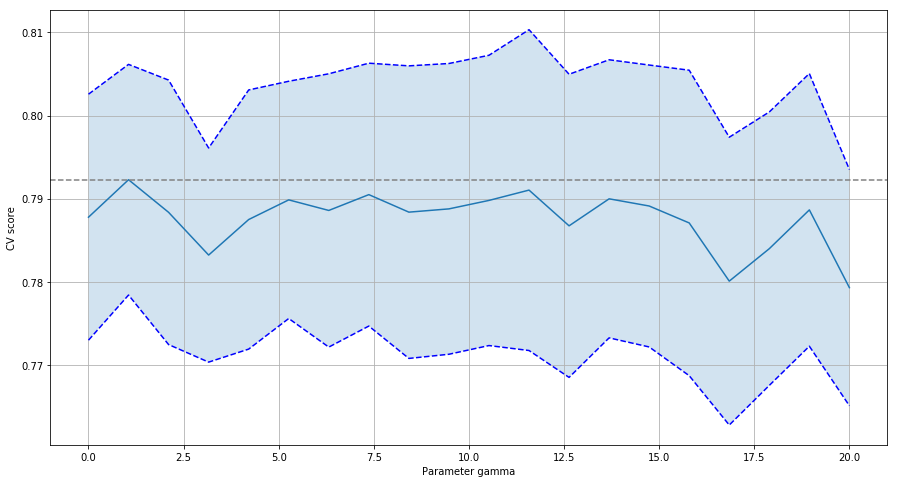

In [25]:
parameter = "gamma"
alphas = np.linspace(0, 20, 20)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(xgb, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, scoring='precision')
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## DecisionTreeClassifier

### max_depth

3


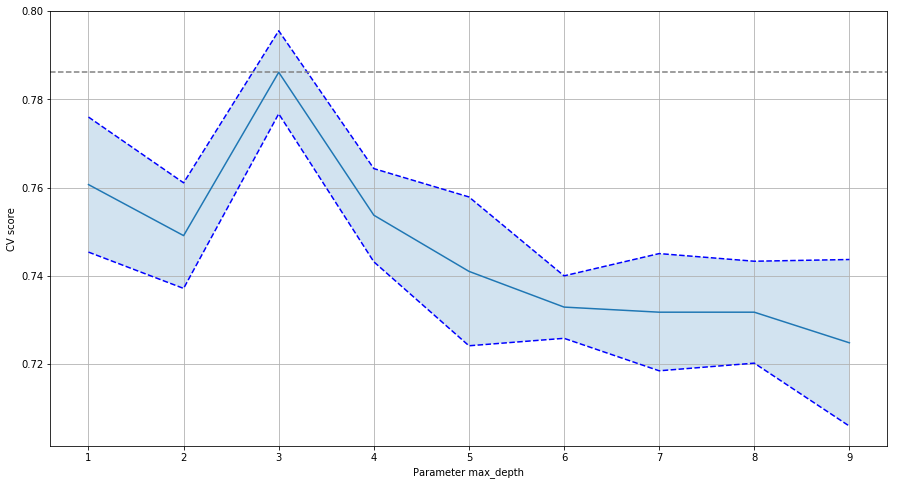

In [26]:
decision_tree = DecisionTreeClassifier()

parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_split

200


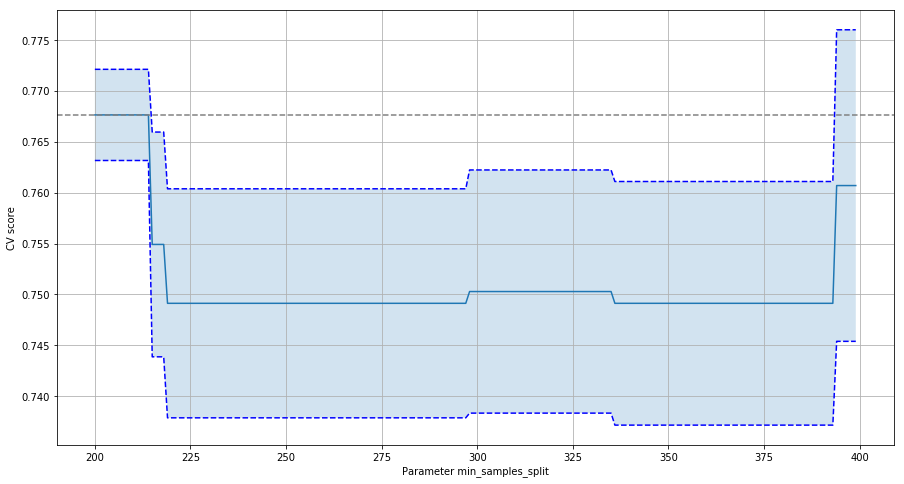

In [27]:
parameter = "min_samples_split"
alphas = range(200,400)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_leaf

125


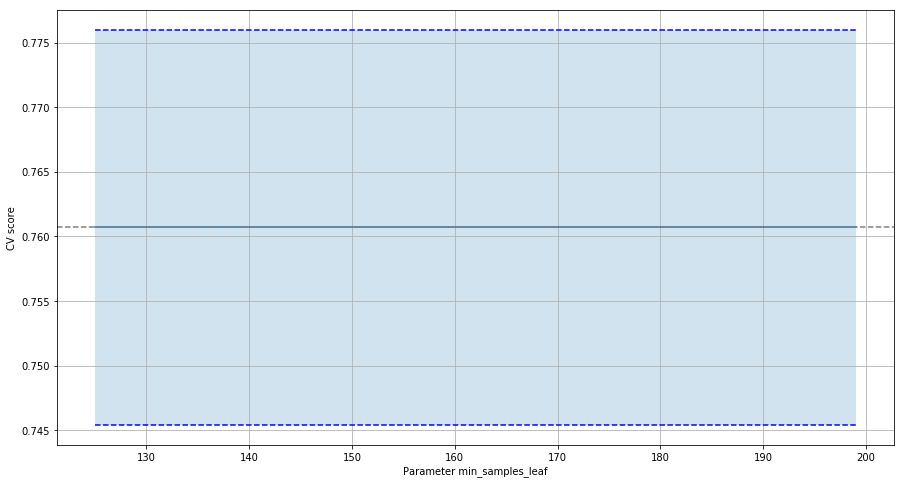

In [28]:
parameter = "min_samples_leaf"
alphas = range(125,200)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(decision_tree, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## random forest

### n_estimators

40


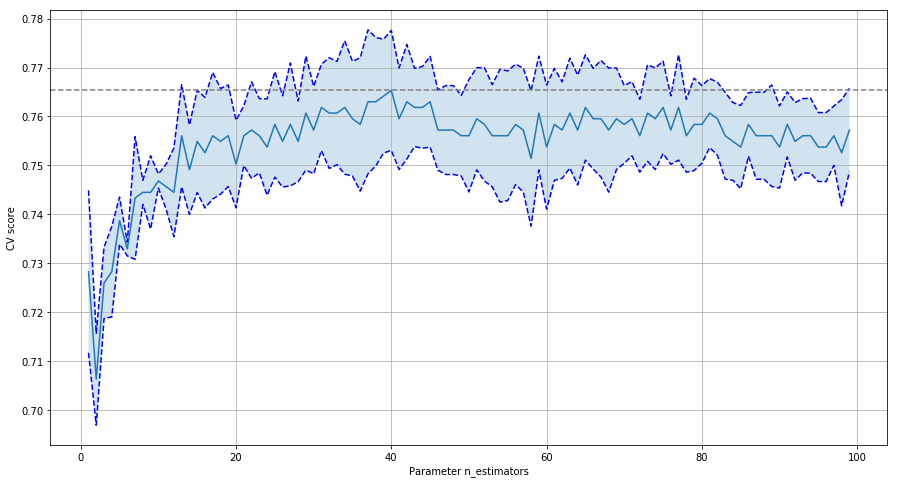

In [46]:
random_forest = RandomForestClassifier(random_state=0)

parameter = "n_estimators"
alphas = range(1,100)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### max_depth

5


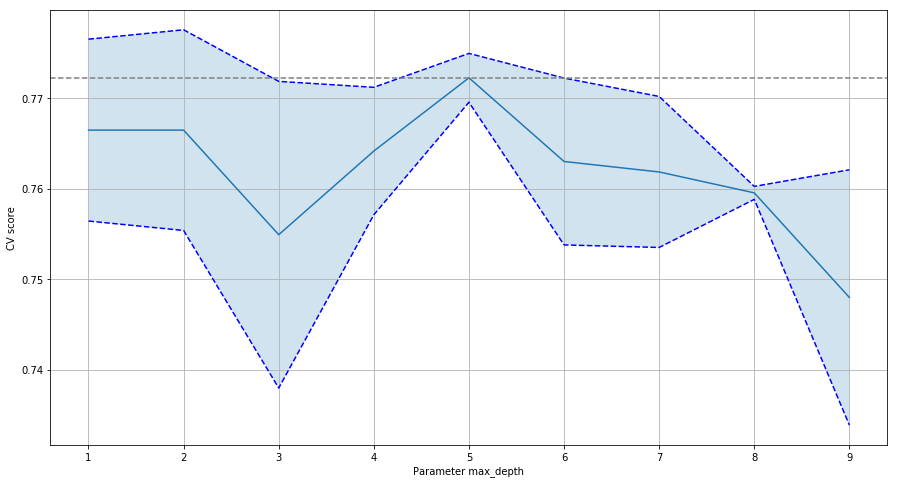

In [47]:
parameter = "max_depth"
alphas = range(1,10)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_split

14


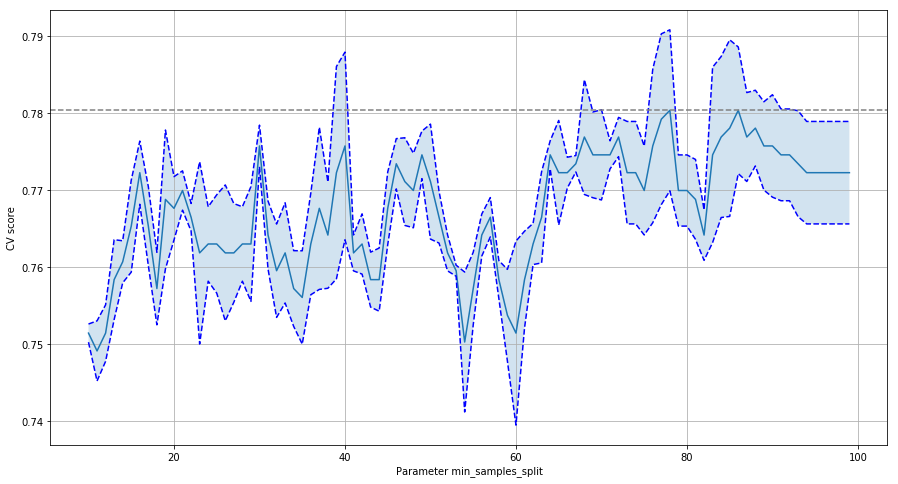

In [48]:
parameter = "min_samples_split"
alphas = range(10,100)
tuned_parameters = [{parameter: alphas}]

print alphas[np.argmax(scores)]
clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### min_samples_leaf

41


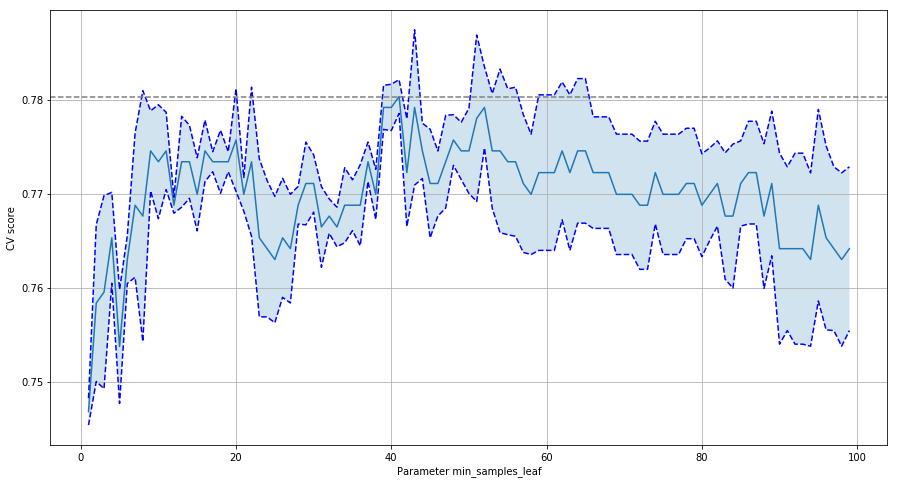

In [49]:
parameter = "min_samples_leaf"
alphas = range(1,100)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(random_forest, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## Regresion logistica

### C

0.0753737373737


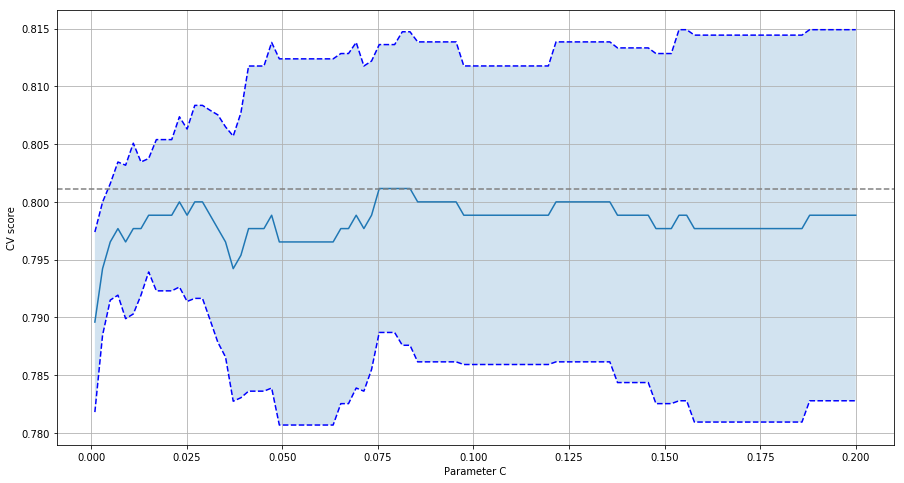

In [39]:
logreg = LogisticRegression()

parameter = "C"
alphas = np.linspace(0.001,0.2,100)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(logreg, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## MPLC

### alpha

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   48.4s finished


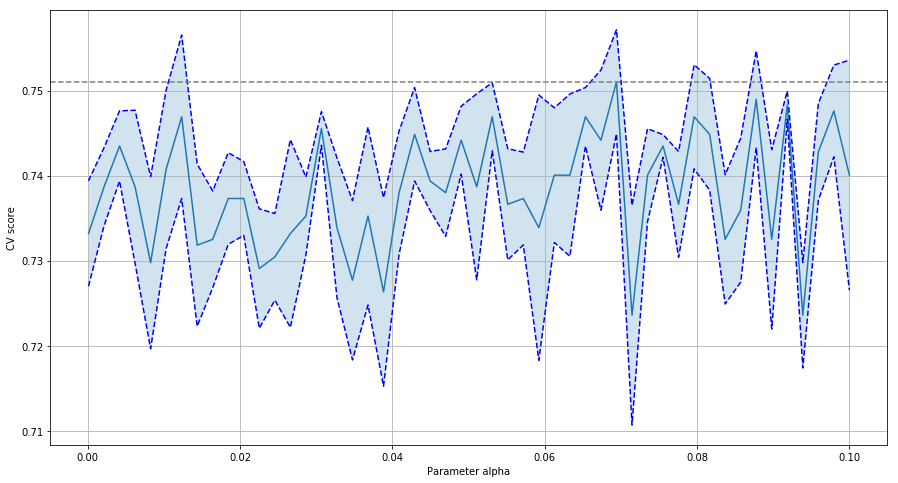

In [19]:
mlpc = MLPClassifier(solver='lbfgs')

parameter = "alpha"
alphas = np.linspace(0.0001,0.1,50)
tuned_parameters = [{parameter: alphas}]

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### hidden_layer_sizes 1

Fitting 3 folds for each of 79 candidates, totalling 237 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   31.5s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:   42.2s finished


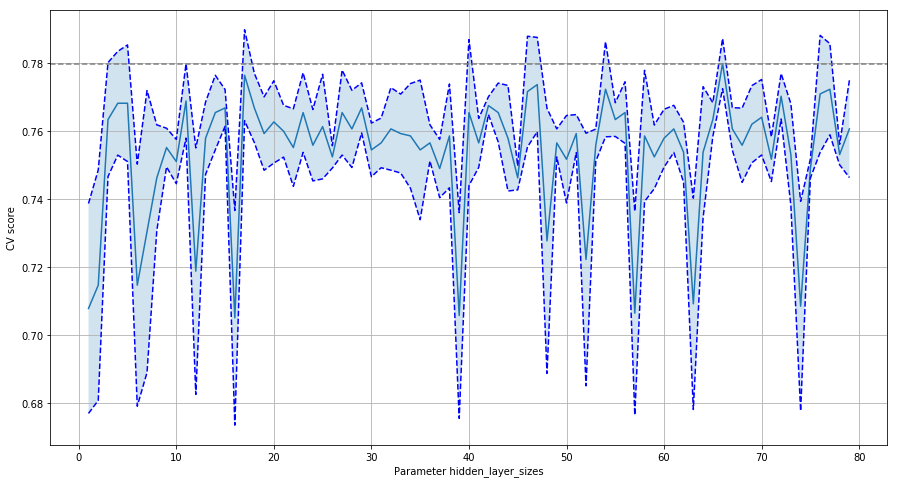

In [20]:
mlpc = MLPClassifier(solver='lbfgs')

parameter = "hidden_layer_sizes"
a = range(1,80)
alphas = [(2,i) for i in a]
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=2)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']


alphas = a
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### hidden_layer_sizes 2

Fitting 3 folds for each of 79 candidates, totalling 237 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 237 out of 237 | elapsed:  1.2min finished


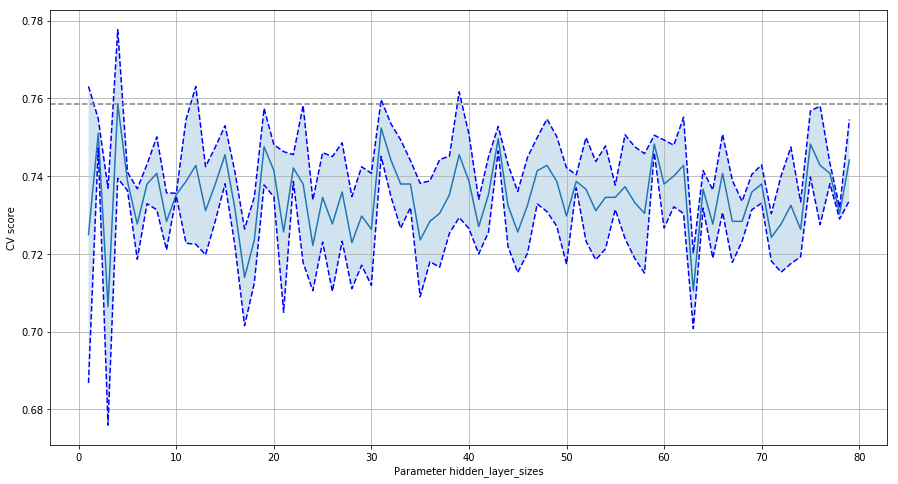

In [ ]:
parameter = "hidden_layer_sizes"
a = range(1,80)
alphas = [(i,30) for i in a]
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(mlpc, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1, verbose=2)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']


alphas = a
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## AdaBoost

### n_estimators

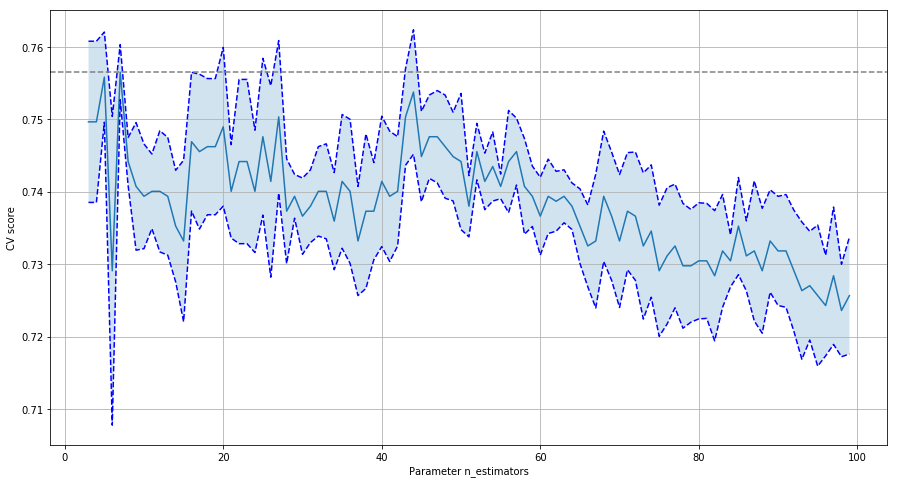

In [15]:
ada = AdaBoostClassifier()

parameter = "n_estimators"
alphas = range(3,100)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(ada, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## learning_rate

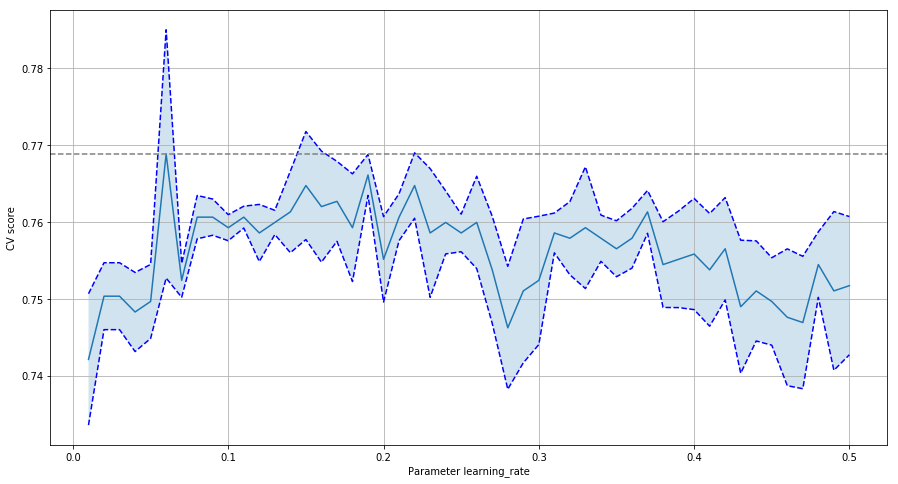

In [25]:
parameter = "learning_rate"
alphas = np.linspace(0.01,0.5,50)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(ada, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### algorithm

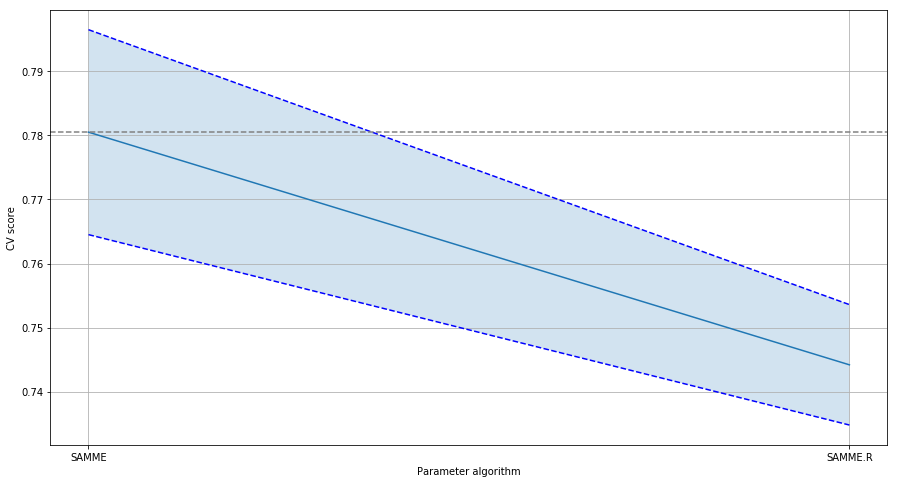

In [26]:
parameter = "algorithm"
alphas = ['SAMME', 'SAMME.R']
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(ada, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

## KNeighborsClassifier

## n_neighbors = 218

35


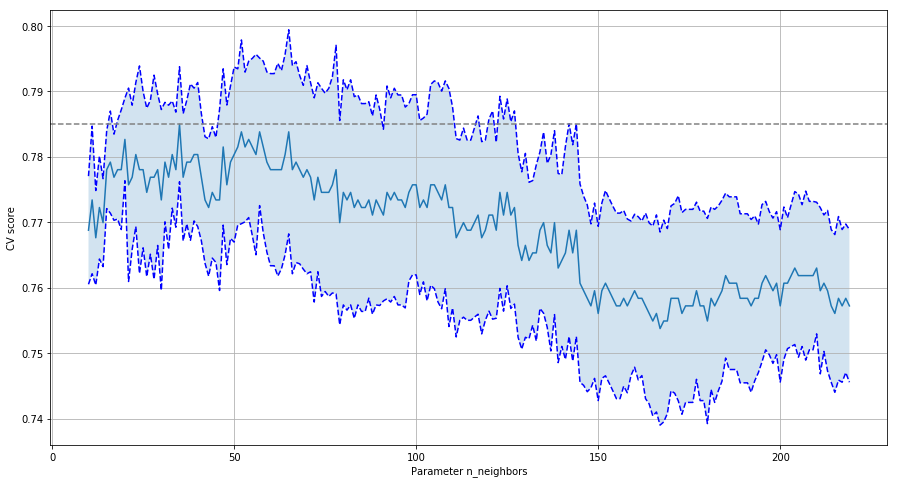

In [37]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

parameter = "n_neighbors"
alphas = range(10,220)
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(knn, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

### weights = "distance"

uniform


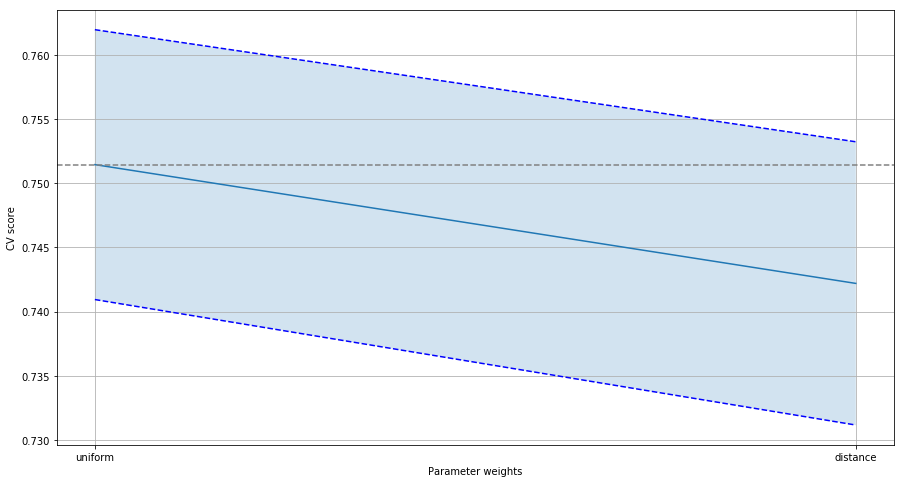

In [35]:
parameter = "weights"
alphas = ["uniform", "distance"]
tuned_parameters = [{parameter: alphas}]
n_folds = 3

clf = GridSearchCV(knn, tuned_parameters, cv=n_folds, refit=False, n_jobs=-1)
clf.fit(X, y)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']

print alphas[np.argmax(scores)]
plt.plot(alphas, scores)
std_error = scores_std / np.sqrt(n_folds)
plt.plot(alphas, scores + std_error, 'b--')
plt.plot(alphas, scores - std_error, 'b--')
std_error = scores_std / np.sqrt(n_folds)
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)
locs, labels = plt.yticks()
#plt.yticks(locs, list(map(lambda x: "%g" % x, locs)))
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.ylabel('CV score')
plt.xlabel('Parameter %s'%parameter)
plt.grid()
#plt.ylim(0, 1.1)
plt.show()

In [45]:
help(random_forest)

Help on RandomForestClassifier in module sklearn.ensemble.forest object:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, f